# Readability Assessment through Learning Techniques

* Readability assessment is a well known problem in natural language processing field. 
* Giving someone the suitable text for his level of comprehension (not so easy and not so hard) could maximize his understanding and enjoyment. 

In this notebook we are trying to assess the readability of a given text regardless of the text topic.

## Corpus
> OneStopEnglish corpus: A new corpus for automatic readability assessment and text simplification  
> Sowmya Vajjala and Ivana Lučić  
> 2018  
> Proceedings of the Thirteenth Workshop on Innovative Use of NLP for Building Educational Applications, pages 297–304. Association for Computational Linguistics.  
> [url](http://aclweb.org/anthology/W18-0535). [bib file](https://aclanthology.coli.uni-saarland.de/papers/W18-0535/w18-0535.bib)

Please cite the above paper if you use this corpus in your research.

[![DOI](https://zenodo.org/badge/128919409.svg)](https://zenodo.org/badge/latestdoi/128919409)

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

Now let's dive into our corpus.

In [2]:
import sys
sys.path.append("/home/ms10596/PycharmProjects/match")
from ipywidgets import interact
from tabulate import tabulate
from IPython.display import display, HTML

from utils.loading import load_glove_embeddings, load_old_corpus
from utils.one_stop_english import load_corpus, corpus_to_words, corpus_to_pos, detokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, Bidirectional,Conv1D,MaxPooling1D,GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np

corpus = load_corpus()
articles_words, tags = corpus_to_words(corpus)
articles_pos, tags = corpus_to_pos(corpus)
old_articles_pos, old_articles_tags = load_old_corpus()

Reading level|Avg. Num. Words|Std. Dev|Number of Articles
---|---|---|---
Elementary|533.17|103.79|189
Intermediate|676.59|117.15|189
Advanced|820.49|162.52|189



In [3]:
@interact
def show_articles(i=(0,188,1), words=(0,1000,1)):
    data = [
        ["Advanced",detokenize(articles_words[i][:words])], 
        ["Intermediate",detokenize(articles_words[i+2][:words])], 
        ["Elementary",detokenize(articles_words[i+1][:words])]
    ]
    headers = ['Reading Level', 'Example']
    display(HTML(tabulate(data,tablefmt='html', headers=headers)+"<style>th,td {font-size: 20px}</style>"))

interactive(children=(IntSlider(value=94, description='i', max=188), IntSlider(value=500, description='words',…

In [4]:
print(articles_words[0][:10])
print(articles_pos[0][:10])

['When', 'you', 'see', 'the', 'word', 'Amazon', ',', 'whats', 'the', 'first']
['WRB', 'PRP', 'VB', 'DT', 'NN', 'NN', ',', 'VBZ', 'DT', 'JJ']


In [5]:
import json
maxlen = 1000 # Cuts off reviews after 1000 words
max_words = 45
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(articles_pos)

with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer.to_json(), ensure_ascii=False))
print(tokenizer.word_index)

{'nn': 1, 'in': 2, 'dt': 3, 'jj': 4, 'nns': 5, 'nnp': 6, ',': 7, '.': 8, 'rb': 9, 'prp': 10, 'vb': 11, 'vbd': 12, 'cc': 13, 'vbz': 14, 'to': 15, 'vbp': 16, 'cd': 17, 'vbn': 18, 'vbg': 19, 'prp$': 20, 'md': 21, 'wdt': 22, 'wrb': 23, 'wp': 24, 'jjr': 25, 'rp': 26, ':': 27, 'jjs': 28, 'ex': 29, 'rbr': 30, 'nnps': 31, '-rrb-': 32, '-lrb-': 33, 'rbs': 34, 'pdt': 35, '$': 36, 'fw': 37, 'uh': 38, 'wp$': 39, 'sym': 40, "''": 41, 'ls': 42, 'pos': 43, '``': 44}


In [7]:
sequences = tokenizer.texts_to_sequences(articles_pos)
old_sequences = tokenizer.texts_to_sequences(old_articles_pos)
print(np.shape(sequences))
print(np.shape(old_sequences))
# print(sequences[0])

(567,)
(183,)


In [8]:
data = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
old_data = pad_sequences(old_sequences, maxlen=maxlen, padding='post', truncating='post')
# print(data[0])
print(np.shape(data))
print(np.shape(old_data))

(567, 1000)
(183, 1000)


In [11]:
print(tags[0])
print(old_articles_tags[0])
tags = np.array(tags)
old_tags = np.array(old_articles_tags)
print(tags.shape)
print(old_tags.shape)

2
0
(567,)
(183,)


In [12]:
data = to_categorical(data)
old_data = to_categorical(old_data)
print(data.shape)
print(old_data.shape)

(567, 1000, 45)
(183, 1000, 45)


In [16]:
np.random.seed(0)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
tags = tags[indices]

old_indices = np.arange(old_data.shape[0])
np.random.shuffle(indices)

old_data = old_data[old_indices]
old_tags = old_tags[old_indices]
print(data.shape)
print(tags.shape)

print(old_data.shape)
print(old_tags.shape)

(567, 1000, 45)
(567,)
(183, 1000, 45)
(183,)


In [63]:
model = Sequential()
model.add(Conv1D(128, 10, activation='relu',kernel_regularizer=l1_l2(l1=0.03, l2=0.5), input_shape=(1000,45)))
model.add(MaxPooling1D(5))
model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
# model.add(MaxPooling1D(5))
# model.add(Conv1D(32, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.0003, l2=0.0003)))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))
# model.summary()
def soft_acc(y_true, y_pred):
    from tensorflow.python.keras import backend as K
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [64]:
es = EarlyStopping(monitor='val_soft_acc',patience=100, mode='max')
cp = ModelCheckpoint('model-{epoch:03d}-{soft_acc:03f}-{val_soft_acc:03f}.h5', verbose=1, monitor='val_soft_acc',save_best_only=True, mode='max')  
model.compile(optimizer=RMSprop(),loss='mse',metrics=[soft_acc])
history = model.fit(data, tags,epochs=1000,  batch_size=50,validation_data=(old_data, old_tags),callbacks=[cp])
# model.save_weights('pre_trained_glove_model.h5')
model.summary()

Train on 567 samples, validate on 183 samples
Epoch 1/1000
550/567 [============================>.] - ETA: 0s - loss: 58.7975 - soft_acc: 0.3200
Epoch 00001: val_soft_acc improved from -inf to 0.38798, saving model to model-001-0.324515-0.387978.h5
567/567 [==============================] - 2s 3ms/step - loss: 58.2030 - soft_acc: 0.3245 - val_loss: 36.8808 - val_soft_acc: 0.3880
Epoch 2/1000
550/567 [============================>.] - ETA: 0s - loss: 28.3591 - soft_acc: 0.3255
Epoch 00002: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 784us/step - loss: 28.0925 - soft_acc: 0.3333 - val_loss: 18.4493 - val_soft_acc: 0.3880
Epoch 3/1000
550/567 [============================>.] - ETA: 0s - loss: 13.7886 - soft_acc: 0.3309
Epoch 00003: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 796us/step - loss: 13.6416 - soft_acc: 0.3333 - val_loss: 8.2957 - val_soft_acc: 0.3880
Epoch 4/1000
550/567 [===================

550/567 [============================>.] - ETA: 0s - loss: 1.5890 - soft_acc: 0.3327
Epoch 00029: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 773us/step - loss: 1.5882 - soft_acc: 0.3333 - val_loss: 1.5177 - val_soft_acc: 0.3880
Epoch 30/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5935 - soft_acc: 0.3327
Epoch 00030: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 769us/step - loss: 1.5934 - soft_acc: 0.3333 - val_loss: 1.5052 - val_soft_acc: 0.3880
Epoch 31/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5822 - soft_acc: 0.3345
Epoch 00031: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 770us/step - loss: 1.5830 - soft_acc: 0.3333 - val_loss: 1.5155 - val_soft_acc: 0.3880
Epoch 32/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5813 - soft_acc: 0.3327
Epoch 00032: val_soft_acc did not improve from 0.38798

Epoch 58/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5646 - soft_acc: 0.3345
Epoch 00058: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 772us/step - loss: 1.5656 - soft_acc: 0.3333 - val_loss: 1.4827 - val_soft_acc: 0.3880
Epoch 59/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5659 - soft_acc: 0.3364
Epoch 00059: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 766us/step - loss: 1.5690 - soft_acc: 0.3333 - val_loss: 1.5132 - val_soft_acc: 0.3880
Epoch 60/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5674 - soft_acc: 0.3291
Epoch 00060: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 767us/step - loss: 1.5633 - soft_acc: 0.3333 - val_loss: 1.4831 - val_soft_acc: 0.3880
Epoch 61/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5736 - soft_acc: 0.3273
Epoch 00061: val_soft_acc did not improv

Epoch 87/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5674 - soft_acc: 0.3327
Epoch 00087: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 778us/step - loss: 1.5669 - soft_acc: 0.3333 - val_loss: 1.4896 - val_soft_acc: 0.3880
Epoch 88/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5607 - soft_acc: 0.3382
Epoch 00088: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 771us/step - loss: 1.5647 - soft_acc: 0.3333 - val_loss: 1.4842 - val_soft_acc: 0.3880
Epoch 89/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5600 - soft_acc: 0.3364
Epoch 00089: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 769us/step - loss: 1.5630 - soft_acc: 0.3333 - val_loss: 1.4873 - val_soft_acc: 0.3880
Epoch 90/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5661 - soft_acc: 0.3327
Epoch 00090: val_soft_acc did not improv

Epoch 116/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5610 - soft_acc: 0.3364
Epoch 00116: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 768us/step - loss: 1.5637 - soft_acc: 0.3333 - val_loss: 1.4740 - val_soft_acc: 0.3880
Epoch 117/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5665 - soft_acc: 0.3291
Epoch 00117: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 767us/step - loss: 1.5623 - soft_acc: 0.3333 - val_loss: 1.4865 - val_soft_acc: 0.3880
Epoch 118/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5652 - soft_acc: 0.3327
Epoch 00118: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 772us/step - loss: 1.5636 - soft_acc: 0.3333 - val_loss: 1.4803 - val_soft_acc: 0.3880
Epoch 119/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5584 - soft_acc: 0.3345
Epoch 00119: val_soft_acc did not im

Epoch 145/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5565 - soft_acc: 0.3345
Epoch 00145: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 767us/step - loss: 1.5571 - soft_acc: 0.3333 - val_loss: 1.4594 - val_soft_acc: 0.3880
Epoch 146/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5615 - soft_acc: 0.3345
Epoch 00146: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 776us/step - loss: 1.5604 - soft_acc: 0.3333 - val_loss: 1.4575 - val_soft_acc: 0.3880
Epoch 147/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5633 - soft_acc: 0.3291
Epoch 00147: val_soft_acc did not improve from 0.38798
567/567 [==============================] - 0s 773us/step - loss: 1.5594 - soft_acc: 0.3333 - val_loss: 1.4723 - val_soft_acc: 0.3880
Epoch 148/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5541 - soft_acc: 0.3364
Epoch 00148: val_soft_acc did not im

Epoch 174/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5495 - soft_acc: 0.3327
Epoch 00174: val_soft_acc did not improve from 0.39344
567/567 [==============================] - 0s 771us/step - loss: 1.5506 - soft_acc: 0.3333 - val_loss: 1.4504 - val_soft_acc: 0.3880
Epoch 175/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5518 - soft_acc: 0.3309
Epoch 00175: val_soft_acc did not improve from 0.39344
567/567 [==============================] - 0s 774us/step - loss: 1.5498 - soft_acc: 0.3333 - val_loss: 1.4419 - val_soft_acc: 0.3880
Epoch 176/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5465 - soft_acc: 0.3364
Epoch 00176: val_soft_acc did not improve from 0.39344
567/567 [==============================] - 0s 773us/step - loss: 1.5484 - soft_acc: 0.3333 - val_loss: 1.4373 - val_soft_acc: 0.3880
Epoch 177/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5522 - soft_acc: 0.3327
Epoch 00177: val_soft_acc did not im

Epoch 202/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5214 - soft_acc: 0.3291
Epoch 00202: val_soft_acc did not improve from 0.50820
567/567 [==============================] - 0s 767us/step - loss: 1.5178 - soft_acc: 0.3351 - val_loss: 1.3836 - val_soft_acc: 0.4426
Epoch 203/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5147 - soft_acc: 0.3291
Epoch 00203: val_soft_acc did not improve from 0.50820
567/567 [==============================] - 0s 770us/step - loss: 1.5109 - soft_acc: 0.3333 - val_loss: 1.3665 - val_soft_acc: 0.4973
Epoch 204/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5121 - soft_acc: 0.3418
Epoch 00204: val_soft_acc did not improve from 0.50820
567/567 [==============================] - 0s 770us/step - loss: 1.5138 - soft_acc: 0.3369 - val_loss: 1.3648 - val_soft_acc: 0.4918
Epoch 205/1000
550/567 [============================>.] - ETA: 0s - loss: 1.5081 - soft_acc: 0.3309
Epoch 00205: val_soft_acc did not im

Epoch 230/1000
550/567 [============================>.] - ETA: 0s - loss: 1.4341 - soft_acc: 0.4109
Epoch 00230: val_soft_acc did not improve from 0.67213
567/567 [==============================] - 0s 767us/step - loss: 1.4293 - soft_acc: 0.4180 - val_loss: 1.3085 - val_soft_acc: 0.6284
Epoch 231/1000
550/567 [============================>.] - ETA: 0s - loss: 1.4340 - soft_acc: 0.4055
Epoch 00231: val_soft_acc did not improve from 0.67213
567/567 [==============================] - 0s 773us/step - loss: 1.4319 - soft_acc: 0.4092 - val_loss: 1.3294 - val_soft_acc: 0.6667
Epoch 232/1000
550/567 [============================>.] - ETA: 0s - loss: 1.4252 - soft_acc: 0.4182
Epoch 00232: val_soft_acc did not improve from 0.67213
567/567 [==============================] - 0s 766us/step - loss: 1.4216 - soft_acc: 0.4268 - val_loss: 1.3407 - val_soft_acc: 0.6503
Epoch 233/1000
550/567 [============================>.] - ETA: 0s - loss: 1.4167 - soft_acc: 0.4382
Epoch 00233: val_soft_acc did not im

550/567 [============================>.] - ETA: 0s - loss: 1.3641 - soft_acc: 0.5255
Epoch 00258: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 771us/step - loss: 1.3713 - soft_acc: 0.5168 - val_loss: 1.3913 - val_soft_acc: 0.6339
Epoch 259/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3616 - soft_acc: 0.5455
Epoch 00259: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 772us/step - loss: 1.3666 - soft_acc: 0.5432 - val_loss: 1.4300 - val_soft_acc: 0.6393
Epoch 260/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3552 - soft_acc: 0.5436
Epoch 00260: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 773us/step - loss: 1.3611 - soft_acc: 0.5379 - val_loss: 1.3760 - val_soft_acc: 0.6448
Epoch 261/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3683 - soft_acc: 0.5436
Epoch 00261: val_soft_acc did not improve from 0.67

Epoch 287/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3521 - soft_acc: 0.6091
Epoch 00287: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 768us/step - loss: 1.3524 - soft_acc: 0.6102 - val_loss: 1.4408 - val_soft_acc: 0.6448
Epoch 288/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3346 - soft_acc: 0.6127
Epoch 00288: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 768us/step - loss: 1.3319 - soft_acc: 0.6173 - val_loss: 1.4198 - val_soft_acc: 0.6557
Epoch 289/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3270 - soft_acc: 0.6073
Epoch 00289: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 765us/step - loss: 1.3243 - soft_acc: 0.6120 - val_loss: 1.5535 - val_soft_acc: 0.5792
Epoch 290/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3346 - soft_acc: 0.6182
Epoch 00290: val_soft_acc did not im

Epoch 316/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3099 - soft_acc: 0.6400
Epoch 00316: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 770us/step - loss: 1.3124 - soft_acc: 0.6384 - val_loss: 1.4245 - val_soft_acc: 0.6339
Epoch 317/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3316 - soft_acc: 0.6218
Epoch 00317: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 769us/step - loss: 1.3300 - soft_acc: 0.6226 - val_loss: 1.4213 - val_soft_acc: 0.6284
Epoch 318/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3168 - soft_acc: 0.6309
Epoch 00318: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 766us/step - loss: 1.3204 - soft_acc: 0.6261 - val_loss: 1.4304 - val_soft_acc: 0.6393
Epoch 319/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3054 - soft_acc: 0.6473
Epoch 00319: val_soft_acc did not im

Epoch 345/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3187 - soft_acc: 0.6600
Epoch 00345: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 772us/step - loss: 1.3154 - soft_acc: 0.6631 - val_loss: 1.4722 - val_soft_acc: 0.6393
Epoch 346/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3042 - soft_acc: 0.6673
Epoch 00346: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 770us/step - loss: 1.3056 - soft_acc: 0.6667 - val_loss: 1.4526 - val_soft_acc: 0.6339
Epoch 347/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3128 - soft_acc: 0.6673
Epoch 00347: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 797us/step - loss: 1.3088 - soft_acc: 0.6720 - val_loss: 1.4682 - val_soft_acc: 0.6339
Epoch 348/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3068 - soft_acc: 0.6509
Epoch 00348: val_soft_acc did not im

Epoch 374/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3017 - soft_acc: 0.6636
Epoch 00374: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 773us/step - loss: 1.3108 - soft_acc: 0.6561 - val_loss: 1.4819 - val_soft_acc: 0.6066
Epoch 375/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2692 - soft_acc: 0.6909
Epoch 00375: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 769us/step - loss: 1.2726 - soft_acc: 0.6896 - val_loss: 1.4841 - val_soft_acc: 0.6448
Epoch 376/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2837 - soft_acc: 0.6855
Epoch 00376: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 767us/step - loss: 1.2848 - soft_acc: 0.6843 - val_loss: 1.5038 - val_soft_acc: 0.6284
Epoch 377/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2898 - soft_acc: 0.6891
Epoch 00377: val_soft_acc did not im

Epoch 403/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2694 - soft_acc: 0.7073
Epoch 00403: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 768us/step - loss: 1.2748 - soft_acc: 0.7002 - val_loss: 1.4769 - val_soft_acc: 0.6120
Epoch 404/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2911 - soft_acc: 0.6727
Epoch 00404: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 772us/step - loss: 1.2928 - soft_acc: 0.6667 - val_loss: 1.5652 - val_soft_acc: 0.5738
Epoch 405/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2926 - soft_acc: 0.6655
Epoch 00405: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 766us/step - loss: 1.2877 - soft_acc: 0.6755 - val_loss: 1.5203 - val_soft_acc: 0.5847
Epoch 406/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2866 - soft_acc: 0.6855
Epoch 00406: val_soft_acc did not im

Epoch 432/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2968 - soft_acc: 0.6564
Epoch 00432: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 769us/step - loss: 1.2959 - soft_acc: 0.6561 - val_loss: 1.5189 - val_soft_acc: 0.6120
Epoch 433/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2498 - soft_acc: 0.7091
Epoch 00433: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 762us/step - loss: 1.2557 - soft_acc: 0.7037 - val_loss: 1.5091 - val_soft_acc: 0.5902
Epoch 434/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2890 - soft_acc: 0.6782
Epoch 00434: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 761us/step - loss: 1.2858 - soft_acc: 0.6843 - val_loss: 1.4903 - val_soft_acc: 0.6230
Epoch 435/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2774 - soft_acc: 0.6600
Epoch 00435: val_soft_acc did not im

Epoch 461/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3128 - soft_acc: 0.6655
Epoch 00461: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 772us/step - loss: 1.3097 - soft_acc: 0.6684 - val_loss: 1.4842 - val_soft_acc: 0.6066
Epoch 462/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2418 - soft_acc: 0.7382
Epoch 00462: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 768us/step - loss: 1.2422 - soft_acc: 0.7372 - val_loss: 1.4757 - val_soft_acc: 0.6393
Epoch 463/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2702 - soft_acc: 0.6964
Epoch 00463: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 770us/step - loss: 1.2738 - soft_acc: 0.6896 - val_loss: 1.5106 - val_soft_acc: 0.5519
Epoch 464/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2737 - soft_acc: 0.6891
Epoch 00464: val_soft_acc did not im

Epoch 490/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2925 - soft_acc: 0.6636
Epoch 00490: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 770us/step - loss: 1.2951 - soft_acc: 0.6631 - val_loss: 1.4809 - val_soft_acc: 0.6503
Epoch 491/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2470 - soft_acc: 0.7218
Epoch 00491: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 767us/step - loss: 1.2456 - soft_acc: 0.7213 - val_loss: 1.5213 - val_soft_acc: 0.6230
Epoch 492/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2600 - soft_acc: 0.7291
Epoch 00492: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 766us/step - loss: 1.2643 - soft_acc: 0.7249 - val_loss: 1.4594 - val_soft_acc: 0.6011
Epoch 493/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2655 - soft_acc: 0.7036
Epoch 00493: val_soft_acc did not im

Epoch 519/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2817 - soft_acc: 0.6855
Epoch 00519: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 773us/step - loss: 1.2807 - soft_acc: 0.6861 - val_loss: 1.5461 - val_soft_acc: 0.5792
Epoch 520/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2634 - soft_acc: 0.6945
Epoch 00520: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 774us/step - loss: 1.2640 - soft_acc: 0.6931 - val_loss: 1.4525 - val_soft_acc: 0.6230
Epoch 521/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2730 - soft_acc: 0.7127
Epoch 00521: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 772us/step - loss: 1.2741 - soft_acc: 0.7072 - val_loss: 1.5924 - val_soft_acc: 0.5792
Epoch 522/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2610 - soft_acc: 0.7182
Epoch 00522: val_soft_acc did not im

Epoch 548/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2890 - soft_acc: 0.6691
Epoch 00548: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 783us/step - loss: 1.2888 - soft_acc: 0.6667 - val_loss: 1.4468 - val_soft_acc: 0.6175
Epoch 549/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2592 - soft_acc: 0.6964
Epoch 00549: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 779us/step - loss: 1.2584 - soft_acc: 0.6984 - val_loss: 1.5084 - val_soft_acc: 0.5956
Epoch 550/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2236 - soft_acc: 0.7364
Epoch 00550: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 782us/step - loss: 1.2246 - soft_acc: 0.7354 - val_loss: 1.4463 - val_soft_acc: 0.6284
Epoch 551/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2703 - soft_acc: 0.7073
Epoch 00551: val_soft_acc did not im

Epoch 577/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2930 - soft_acc: 0.6618
Epoch 00577: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 781us/step - loss: 1.2916 - soft_acc: 0.6631 - val_loss: 1.4486 - val_soft_acc: 0.6284
Epoch 578/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2403 - soft_acc: 0.7145
Epoch 00578: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 782us/step - loss: 1.2400 - soft_acc: 0.7160 - val_loss: 1.4981 - val_soft_acc: 0.5902
Epoch 579/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2684 - soft_acc: 0.7055
Epoch 00579: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 784us/step - loss: 1.2739 - soft_acc: 0.7002 - val_loss: 1.6615 - val_soft_acc: 0.5246
Epoch 580/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2311 - soft_acc: 0.7455
Epoch 00580: val_soft_acc did not im

Epoch 606/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2537 - soft_acc: 0.7291
Epoch 00606: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 786us/step - loss: 1.2567 - soft_acc: 0.7266 - val_loss: 1.5747 - val_soft_acc: 0.5792
Epoch 607/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2279 - soft_acc: 0.7327
Epoch 00607: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 781us/step - loss: 1.2330 - soft_acc: 0.7302 - val_loss: 1.6886 - val_soft_acc: 0.5137
Epoch 608/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2508 - soft_acc: 0.7436
Epoch 00608: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 789us/step - loss: 1.2504 - soft_acc: 0.7425 - val_loss: 1.4417 - val_soft_acc: 0.6120
Epoch 609/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2426 - soft_acc: 0.7364
Epoch 00609: val_soft_acc did not im

Epoch 635/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2630 - soft_acc: 0.7200
Epoch 00635: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 783us/step - loss: 1.2627 - soft_acc: 0.7213 - val_loss: 1.4804 - val_soft_acc: 0.6284
Epoch 636/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2542 - soft_acc: 0.7364
Epoch 00636: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 780us/step - loss: 1.2517 - soft_acc: 0.7390 - val_loss: 1.5426 - val_soft_acc: 0.6120
Epoch 637/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2109 - soft_acc: 0.7673
Epoch 00637: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 779us/step - loss: 1.2124 - soft_acc: 0.7672 - val_loss: 1.7213 - val_soft_acc: 0.4973
Epoch 638/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2478 - soft_acc: 0.7327
Epoch 00638: val_soft_acc did not im

Epoch 664/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2835 - soft_acc: 0.6709
Epoch 00664: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 781us/step - loss: 1.2809 - soft_acc: 0.6755 - val_loss: 1.4660 - val_soft_acc: 0.6393
Epoch 665/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2368 - soft_acc: 0.7364
Epoch 00665: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 777us/step - loss: 1.2379 - soft_acc: 0.7372 - val_loss: 1.5292 - val_soft_acc: 0.6011
Epoch 666/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2586 - soft_acc: 0.7109
Epoch 00666: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 785us/step - loss: 1.2607 - soft_acc: 0.7108 - val_loss: 1.5218 - val_soft_acc: 0.6066
Epoch 667/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2582 - soft_acc: 0.7182
Epoch 00667: val_soft_acc did not im

Epoch 693/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2578 - soft_acc: 0.7364
Epoch 00693: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 784us/step - loss: 1.2594 - soft_acc: 0.7302 - val_loss: 1.5274 - val_soft_acc: 0.6230
Epoch 694/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2295 - soft_acc: 0.7582
Epoch 00694: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 777us/step - loss: 1.2307 - soft_acc: 0.7549 - val_loss: 1.5511 - val_soft_acc: 0.6066
Epoch 695/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2664 - soft_acc: 0.7055
Epoch 00695: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 790us/step - loss: 1.2668 - soft_acc: 0.7037 - val_loss: 1.5717 - val_soft_acc: 0.5847
Epoch 696/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2394 - soft_acc: 0.7255
Epoch 00696: val_soft_acc did not im

Epoch 722/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2359 - soft_acc: 0.7418
Epoch 00722: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 789us/step - loss: 1.2343 - soft_acc: 0.7460 - val_loss: 1.5044 - val_soft_acc: 0.6339
Epoch 723/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2487 - soft_acc: 0.7182
Epoch 00723: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 781us/step - loss: 1.2480 - soft_acc: 0.7178 - val_loss: 1.5847 - val_soft_acc: 0.5792
Epoch 724/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2651 - soft_acc: 0.7145
Epoch 00724: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 788us/step - loss: 1.2659 - soft_acc: 0.7160 - val_loss: 1.5800 - val_soft_acc: 0.5847
Epoch 725/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2222 - soft_acc: 0.7473
Epoch 00725: val_soft_acc did not im

Epoch 751/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2546 - soft_acc: 0.7055
Epoch 00751: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 794us/step - loss: 1.2613 - soft_acc: 0.6984 - val_loss: 1.6939 - val_soft_acc: 0.5082
Epoch 752/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2331 - soft_acc: 0.7255
Epoch 00752: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 790us/step - loss: 1.2355 - soft_acc: 0.7231 - val_loss: 1.4854 - val_soft_acc: 0.6393
Epoch 753/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2208 - soft_acc: 0.7582
Epoch 00753: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 788us/step - loss: 1.2235 - soft_acc: 0.7566 - val_loss: 1.4600 - val_soft_acc: 0.6066
Epoch 754/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2454 - soft_acc: 0.7164
Epoch 00754: val_soft_acc did not im

Epoch 780/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2439 - soft_acc: 0.7327
Epoch 00780: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 776us/step - loss: 1.2422 - soft_acc: 0.7319 - val_loss: 1.5294 - val_soft_acc: 0.5956
Epoch 781/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2705 - soft_acc: 0.6727
Epoch 00781: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 785us/step - loss: 1.2718 - soft_acc: 0.6702 - val_loss: 1.4735 - val_soft_acc: 0.6230
Epoch 782/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2445 - soft_acc: 0.7218
Epoch 00782: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 785us/step - loss: 1.2437 - soft_acc: 0.7231 - val_loss: 1.4477 - val_soft_acc: 0.6557
Epoch 783/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2208 - soft_acc: 0.7527
Epoch 00783: val_soft_acc did not im

Epoch 809/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2156 - soft_acc: 0.7618
Epoch 00809: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 781us/step - loss: 1.2214 - soft_acc: 0.7531 - val_loss: 1.5786 - val_soft_acc: 0.5738
Epoch 810/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2320 - soft_acc: 0.7327
Epoch 00810: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 781us/step - loss: 1.2333 - soft_acc: 0.7319 - val_loss: 1.4935 - val_soft_acc: 0.5847
Epoch 811/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2628 - soft_acc: 0.7018
Epoch 00811: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 782us/step - loss: 1.2622 - soft_acc: 0.7019 - val_loss: 1.4766 - val_soft_acc: 0.6175
Epoch 812/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2285 - soft_acc: 0.7418
Epoch 00812: val_soft_acc did not im

Epoch 838/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2261 - soft_acc: 0.7545
Epoch 00838: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 775us/step - loss: 1.2271 - soft_acc: 0.7531 - val_loss: 1.4445 - val_soft_acc: 0.6339
Epoch 839/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2534 - soft_acc: 0.7091
Epoch 00839: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 783us/step - loss: 1.2519 - soft_acc: 0.7108 - val_loss: 1.5667 - val_soft_acc: 0.5902
Epoch 840/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2808 - soft_acc: 0.6800
Epoch 00840: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 782us/step - loss: 1.2778 - soft_acc: 0.6843 - val_loss: 1.5541 - val_soft_acc: 0.5902
Epoch 841/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2625 - soft_acc: 0.7127
Epoch 00841: val_soft_acc did not im

Epoch 867/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2366 - soft_acc: 0.7345
Epoch 00867: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 785us/step - loss: 1.2384 - soft_acc: 0.7302 - val_loss: 1.6024 - val_soft_acc: 0.5738
Epoch 868/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2338 - soft_acc: 0.7327
Epoch 00868: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 781us/step - loss: 1.2323 - soft_acc: 0.7337 - val_loss: 1.6558 - val_soft_acc: 0.5355
Epoch 869/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2290 - soft_acc: 0.7364
Epoch 00869: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 786us/step - loss: 1.2305 - soft_acc: 0.7337 - val_loss: 1.5879 - val_soft_acc: 0.5628
Epoch 870/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2509 - soft_acc: 0.7236
Epoch 00870: val_soft_acc did not im

Epoch 896/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2236 - soft_acc: 0.7727
Epoch 00896: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 781us/step - loss: 1.2253 - soft_acc: 0.7690 - val_loss: 1.4552 - val_soft_acc: 0.6230
Epoch 897/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2832 - soft_acc: 0.7000
Epoch 00897: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 781us/step - loss: 1.2808 - soft_acc: 0.7002 - val_loss: 1.4628 - val_soft_acc: 0.6230
Epoch 898/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2495 - soft_acc: 0.7382
Epoch 00898: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 781us/step - loss: 1.2498 - soft_acc: 0.7354 - val_loss: 1.5670 - val_soft_acc: 0.5956
Epoch 899/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2003 - soft_acc: 0.7982
Epoch 00899: val_soft_acc did not im

Epoch 925/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2064 - soft_acc: 0.7818
Epoch 00925: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 780us/step - loss: 1.2054 - soft_acc: 0.7831 - val_loss: 1.4854 - val_soft_acc: 0.5956
Epoch 926/1000
550/567 [============================>.] - ETA: 0s - loss: 1.3042 - soft_acc: 0.6455
Epoch 00926: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 791us/step - loss: 1.3097 - soft_acc: 0.6402 - val_loss: 1.7103 - val_soft_acc: 0.5191
Epoch 927/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2344 - soft_acc: 0.7309
Epoch 00927: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 781us/step - loss: 1.2312 - soft_acc: 0.7354 - val_loss: 1.5423 - val_soft_acc: 0.6066
Epoch 928/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2410 - soft_acc: 0.7127
Epoch 00928: val_soft_acc did not im

Epoch 954/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2270 - soft_acc: 0.7618
Epoch 00954: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 781us/step - loss: 1.2265 - soft_acc: 0.7619 - val_loss: 1.4763 - val_soft_acc: 0.6175
Epoch 955/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2598 - soft_acc: 0.7255
Epoch 00955: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 780us/step - loss: 1.2604 - soft_acc: 0.7213 - val_loss: 1.4684 - val_soft_acc: 0.6066
Epoch 956/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2357 - soft_acc: 0.7400
Epoch 00956: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 783us/step - loss: 1.2311 - soft_acc: 0.7460 - val_loss: 1.5584 - val_soft_acc: 0.5902
Epoch 957/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2493 - soft_acc: 0.7164
Epoch 00957: val_soft_acc did not im

Epoch 983/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2293 - soft_acc: 0.7255
Epoch 00983: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 777us/step - loss: 1.2347 - soft_acc: 0.7213 - val_loss: 1.5781 - val_soft_acc: 0.5847
Epoch 984/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2395 - soft_acc: 0.7255
Epoch 00984: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 789us/step - loss: 1.2504 - soft_acc: 0.7178 - val_loss: 1.4239 - val_soft_acc: 0.6284
Epoch 985/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2058 - soft_acc: 0.7782
Epoch 00985: val_soft_acc did not improve from 0.67760
567/567 [==============================] - 0s 789us/step - loss: 1.2053 - soft_acc: 0.7760 - val_loss: 1.4785 - val_soft_acc: 0.6011
Epoch 986/1000
550/567 [============================>.] - ETA: 0s - loss: 1.2653 - soft_acc: 0.7309
Epoch 00986: val_soft_acc did not im

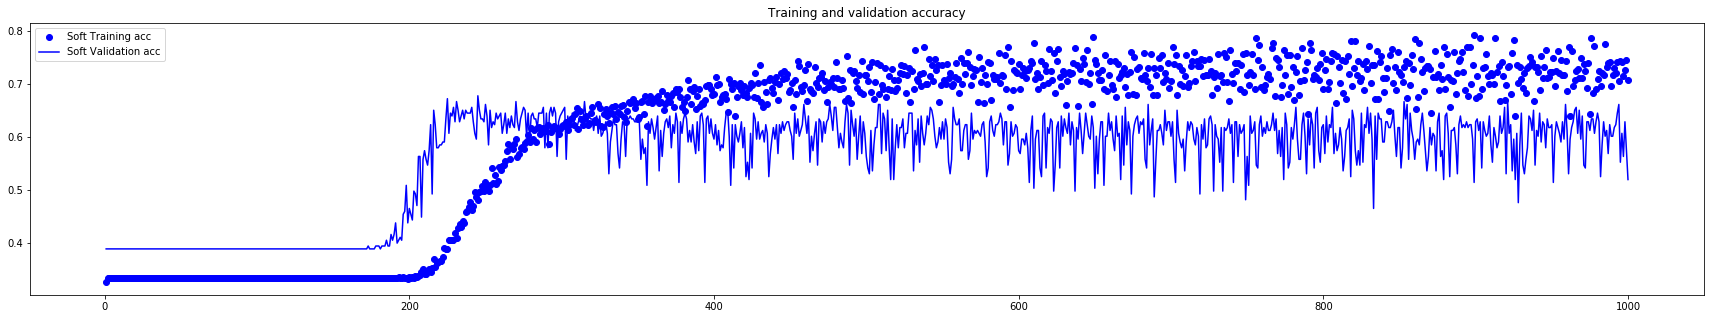

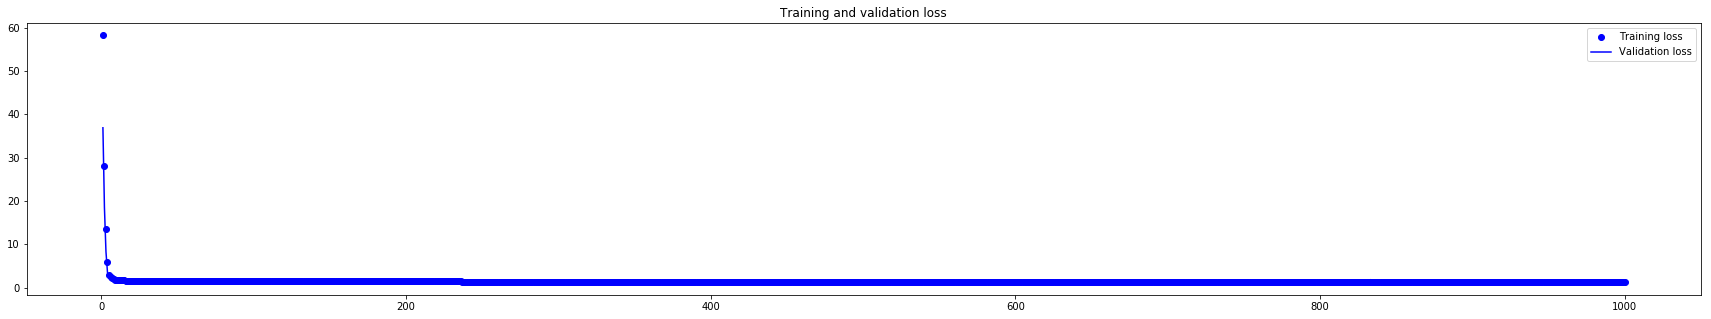

In [65]:
import matplotlib.pyplot as plt

soft_acc = history.history['soft_acc']
soft_val_acc = history.history['val_soft_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(soft_acc) + 1)
plt.figure(figsize=(30,5))
plt.plot(epochs, soft_acc, 'bo', label='Soft Training acc')
plt.plot(epochs, soft_val_acc, 'b', label='Soft Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure(figsize=(30,5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()




In [29]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvs_scores = []
for train, test in kfold.split(data, tags):
    model = Sequential()
    model.add(Conv1D(128, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.01, l2=0.01), input_shape=(1000,45)))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(32, 5, activation='relu',kernel_regularizer=l1_l2(l1=0.0003, l2=0.0003)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1))
    # model.summary()
    def soft_acc(y_true, y_pred):
        from tensorflow.python.keras import backend as K
        return K.mean(K.equal(K.round(y_true), K.round(y_pred)))
    model.compile(optimizer=RMSprop(),loss='mse',metrics=[soft_acc])
    model.fit(data[train], tags[train], epochs=2000, verbose=0)
    scores = model.evaluate(data[test], tags[test], verbose=0)
    print(scores[1]*100)
    cvs_scores.append(scores[1]*100)
print("Accuracy:", np.mean(cvs_scores),"std:", np.std(cvs_scores))

61.40350887649938
66.66666792150129
49.122808272378485
45.614034617156314
64.91228080632393
54.385964807711154
57.89473715581393
73.68421178115042
64.91228101546305
55.555556217829384
Accuracy: 59.415205147182725 std: 8.120868247309904
